In [1]:
#Now to mount drive here
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#after mounting drive we need to unzip the folder and use it
import zipfile

zip_file_path = '/content/drive/MyDrive/flavia/archive(1).zip'
target_directory = '/content'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('Found GPU. Using GPU.')
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
else:
    try:
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print('Found TPU. Using TPU.')
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print('No GPU or TPU found. Using CPU.')
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

print('Number of replicas: {}'.format(strategy.num_replicas_in_sync))

Found GPU. Using GPU.
Number of devices: 1
Number of replicas: 1


In [4]:
import shutil
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

input_directory = '/content/Leaves'
output_directory = '/content/Leaves_no_bg'
csv_file = '/content/Leaves/all.csv'

df = pd.read_csv(csv_file)
for index, row in df.iterrows():
    image_name = row['id']
    class_number = row['y']
    class_directory = os.path.join(output_directory, str(class_number))
    os.makedirs(class_directory, exist_ok=True)
    input_path = os.path.join(input_directory, image_name)
    output_path = os.path.join(class_directory, image_name)
    shutil.copyfile(input_path, output_path)

print("Images organized into class-specific folders after background removal.")

Images organized into class-specific folders after background removal.


In [5]:
from google.colab.patches import cv2_imshow
import cv2

def preprocess_image(image_path):
    # Read the image
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (224, 224))

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Apply threshold to obtain a binary mask for the white background
    _, mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)

    # Invert the mask to get the foreground
    mask = cv2.bitwise_not(mask)

    # Apply Gaussian Blur to the image
    blurred_image = cv2.GaussianBlur(original_image, (15, 15), 0)

    # Sharpen the image
    sharpened_image = cv2.addWeighted(blurred_image, 1.5, original_image, -0.5, 0)

    # Combine the sharpened image with the white background mask
    result_image = cv2.bitwise_and(sharpened_image, sharpened_image, mask=mask)

    return result_image

In [6]:
import numpy as np

dataset_path = "/content/Leaves_no_bg"
output_path = "/content/Leaves_preprocessed"

data = []
labels = []

with strategy.scope():
  for class_folder in os.listdir(dataset_path):
      class_folder_path = os.path.join(dataset_path, class_folder)
      label = int(class_folder)

      for image_name in os.listdir(class_folder_path):
          image_path = os.path.join(class_folder_path, image_name)
          data.append(preprocess_image(image_path))
          labels.append(label)


data = np.array(data)
labels = np.array(labels)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np

with strategy.scope():
    def create_resnet50(input_shape=(224, 224, 3), num_classes=32):
        base_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
        model = models.Sequential()
        model.add(base_model)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

        return model
    input_shape_resnet = (224, 224, 3)
    num_classes = len(np.unique(labels))

    model = create_resnet50(input_shape_resnet, num_classes)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/35
172/172 [==============================] - 71s 140ms/step - loss: 2.8547 - accuracy: 0.2332 - val_loss: 62.9660 - val_accuracy: 0.0458
Epoch 2/35
172/172 [==============================] - 19s 113ms/step - loss: 1.9503 - accuracy: 0.4133 - val_loss: 2.0825 - val_accuracy: 0.4575
Epoch 3/35
172/172 [==============================] - 20s 114ms/step - loss: 1.4322 - accuracy: 0.5692 - val_loss: 0.9350 - val_accuracy: 0.6732
Epoch 4/35
172/172 [==============================] - 19s 111ms/step - loss: 1.0674 - accuracy: 0.6669 - val_loss: 1.9435 - val_accuracy: 0.4771
Epoch 5/35
172/172 [==============================] - 20s 117ms/step - loss: 0.8538 - accuracy: 0.7325 - val_loss: 2.5367 - val_accuracy: 0.5033
Epoch 6/35
172/172 [==============================] - 19s 113ms/step - loss: 0.7501 - accuracy: 0.7660 - val_loss: 0.3275 - val_accuracy: 0.8758
Epoch 7/35
172/172 [==============================] - 19s 112ms/

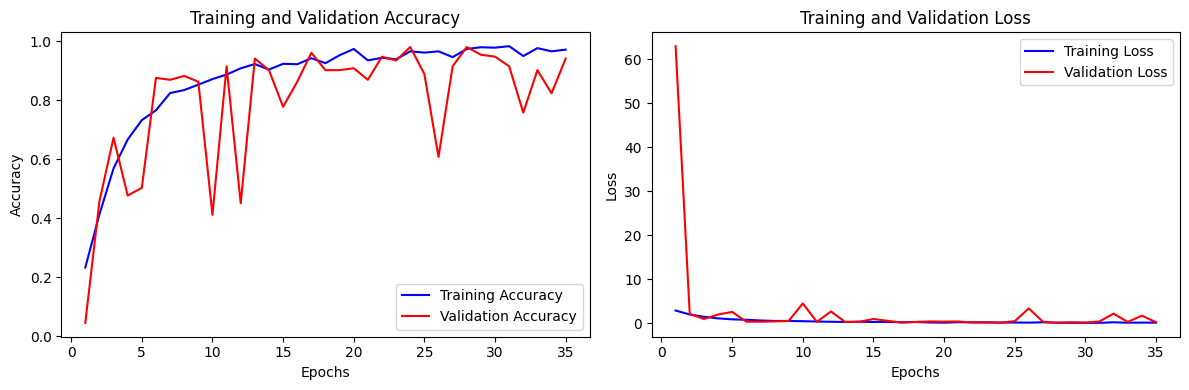

In [18]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/30
172/172 [==============================] - 50s 116ms/step - loss: 2.8354 - accuracy: 0.2063 - val_loss: 712.1041 - val_accuracy: 0.0327
Epoch 2/30
172/172 [==============================] - 18s 107ms/step - loss: 1.9898 - accuracy: 0.4089 - val_loss: 8.3896 - val_accuracy: 0.1307
Epoch 3/30
172/172 [==============================] - 18s 102ms/step - loss: 1.4666 - accuracy: 0.5430 - val_loss: 1.6115 - val_accuracy: 0.5033
Epoch 4/30
172/172 [==============================] - 19s 109ms/step - loss: 1.1979 - accuracy: 0.6261 - val_loss: 1.2696 - val_accuracy: 0.6732
Epoch 5/30
172/172 [==============================] - 17s 102ms/step - loss: 0.9328 - accuracy: 0.7041 - val_loss: 0.9584 - val_accuracy: 0.6928
Epoch 6/30
172/172 [==============================] - 17s 102ms/step - loss: 0.6959 - accuracy: 0.7828 - val_loss: 0.7727 - val_accuracy: 0.7647
Epoch 7/30
172/172 [==============================] - 18s 102ms

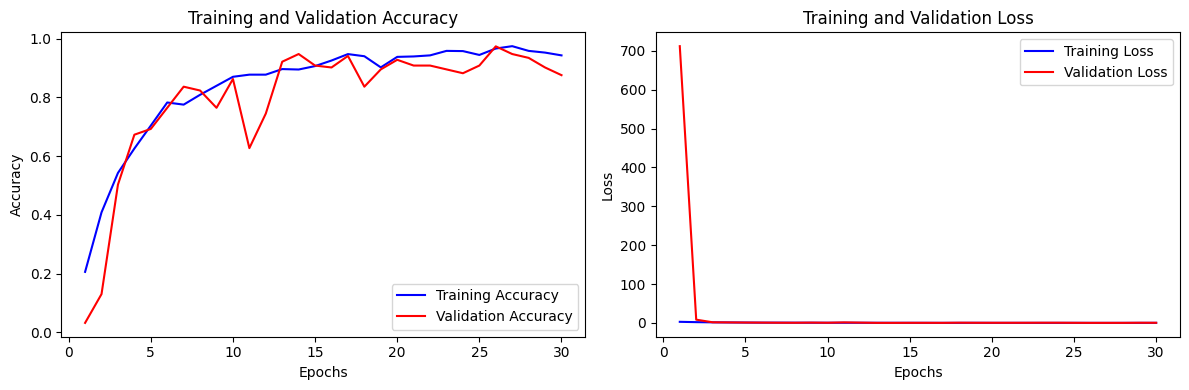

In [26]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.ResNet152V2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

234545216/234545216 [==============================] - 3s 0us/step
Epoch 1/30
172/172 [==============================] - 143s 281ms/step - loss: 3.3402 - accuracy: 0.0765 - val_loss: 90.3560 - val_accuracy: 0.0523
Epoch 2/30
172/172 [==============================] - 44s 254ms/step - loss: 3.0398 - accuracy: 0.1137 - val_loss: 210.1111 - val_accuracy: 0.0458
Epoch 3/30
172/172 [==============================] - 44s 253ms/step - loss: 2.7318 - accuracy: 0.1764 - val_loss: 4.3543 - val_accuracy: 0.1373
Epoch 4/30
172/172 [==============================] - 44s 254ms/step - loss: 2.3802 - accuracy: 0.2500 - val_loss: 6.2528 - val_accuracy: 0.1111
Epoch 5/30
172/172 [==============================] - 44s 255ms/step - loss: 2.1335 - accuracy: 0.3127 - val_loss: 22.3842 - val_accuracy: 0.0458
Epoch 6/30
172/172 [==============================] - 44s 255ms/step - loss: 1.8149 - accuracy: 0.4031 - val_loss: 2.2636 - val_accuracy: 0.2745
Epoch 7/30
172/172 [==============================] - 45s 

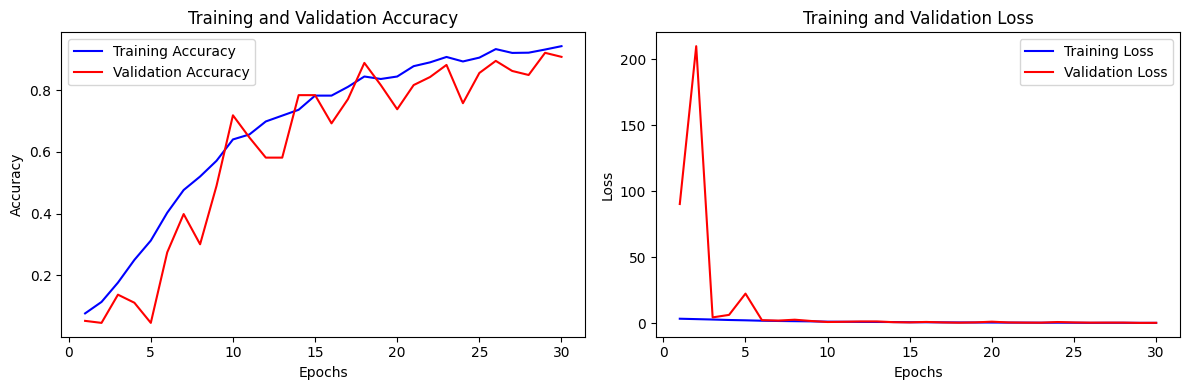

In [28]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.ResNet101V2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

171317808/171317808 [==============================] - 2s 0us/step
Epoch 1/30
172/172 [==============================] - 108s 193ms/step - loss: 3.1260 - accuracy: 0.1472 - val_loss: 22.4729 - val_accuracy: 0.0784
Epoch 2/30
172/172 [==============================] - 30s 172ms/step - loss: 2.3243 - accuracy: 0.2996 - val_loss: 7.2774 - val_accuracy: 0.0980
Epoch 3/30
172/172 [==============================] - 31s 181ms/step - loss: 1.8063 - accuracy: 0.4410 - val_loss: 5.1573 - val_accuracy: 0.1373
Epoch 4/30
172/172 [==============================] - 31s 182ms/step - loss: 1.4645 - accuracy: 0.5547 - val_loss: 3.0601 - val_accuracy: 0.3268
Epoch 5/30
172/172 [==============================] - 31s 179ms/step - loss: 1.2188 - accuracy: 0.6115 - val_loss: 1.4310 - val_accuracy: 0.6209
Epoch 6/30
172/172 [==============================] - 31s 182ms/step - loss: 0.9833 - accuracy: 0.6698 - val_loss: 1.4361 - val_accuracy: 0.5163
Epoch 7/30
172/172 [==============================] - 31s 180

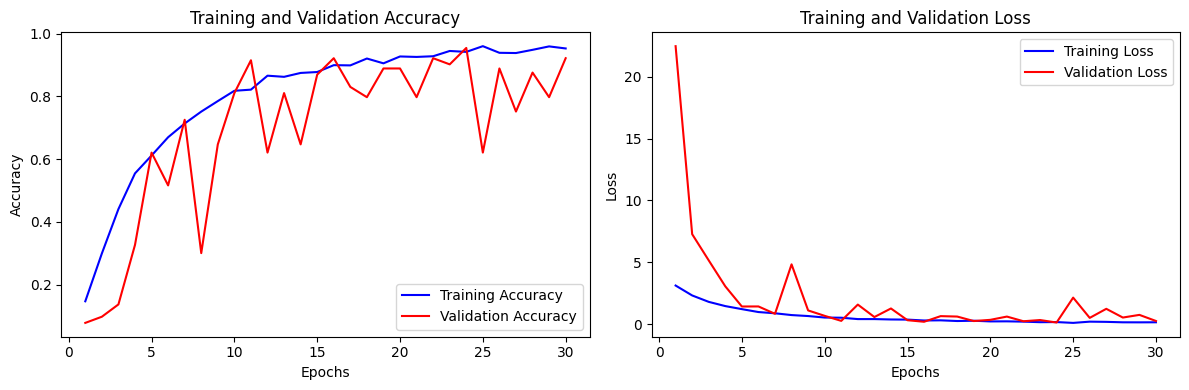

In [10]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
  base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
  model = models.Sequential()
  model.add(base_model)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32, activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


  num_epochs = 30
  batch_size = 8

  history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

  test_loss, test_accuracy = model.evaluate(X_test, y_test)
  print(f'Test Loss: {test_loss:.4f}')
  print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/30
172/172 [==============================] - 32s 164ms/step - loss: 3.6090 - accuracy: 0.1560 - val_loss: 2.6534 - val_accuracy: 0.1699
Epoch 2/30
172/172 [==============================] - 25s 147ms/step - loss: 2.4050 - accuracy: 0.2930 - val_loss: 1.9707 - val_accuracy: 0.3725
Epoch 3/30
172/172 [==============================] - 25s 144ms/step - loss: 1.9557 - accuracy: 0.3848 - val_loss: 1.4601 - val_accuracy: 0.5490
Epoch 4/30
172/172 [==============================] - 25s 146ms/step - loss: 1.6028 - accuracy: 0.5044 - val_loss: 1.3576 - val_accuracy: 0.5752
Epoch 5/30
172/172 [==============================] - 25s 145ms/step - loss: 1.4408 - accuracy: 0.5408 - val_loss: 1.3606 - val_accuracy: 0.5752
Epoch 6/30
172/172 [==============================] - 25s 144ms/step - loss: 1.2868 - accuracy: 0.5999 - val_loss: 1.1409 - val_accuracy: 0.5948
Epoch 7/30
172/172 [==============================] - 24s 142ms/step - loss: 1.1404 - accuracy: 0.6487 - val_loss: 1.1317 - val_ac

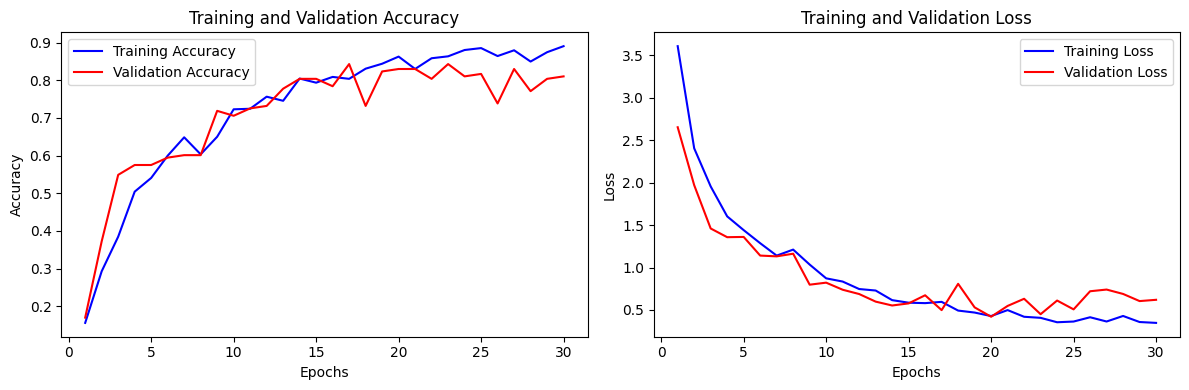

In [22]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/30
172/172 [==============================] - 69s 152ms/step - loss: 3.0874 - accuracy: 0.1567 - val_loss: 5.3634 - val_accuracy: 0.0261
Epoch 2/30
172/172 [==============================] - 19s 113ms/step - loss: 2.3629 - accuracy: 0.3149 - val_loss: 2.9028 - val_accuracy: 0.3203
Epoch 3/30
172/172 [==============================] - 21s 123ms/step - loss: 1.7971 - accuracy: 0.4439 - val_loss: 10.2033 - val_accuracy: 0.2353
Epoch 4/30
172/172 [==============================] - 22s 129ms/step - loss: 1.5413 - accuracy: 0.5124 - val_loss: 1.5234 - val_accuracy: 0.6405
Epoch 5/30
172/172 [==============================] - 22s 129ms/step - loss: 1.3613 - accuracy: 0.5590 - val_loss: 2.0094 - val_accuracy: 0.6209
Epoch 6/30
172/172 [==============================] - 19s 112ms/step - loss: 1.1041 - accuracy: 0.6443 - val_loss: 2.1246 - val_accuracy: 0.5490
Epoch 7/30
172/172 [==============================] - 16s 95ms/s

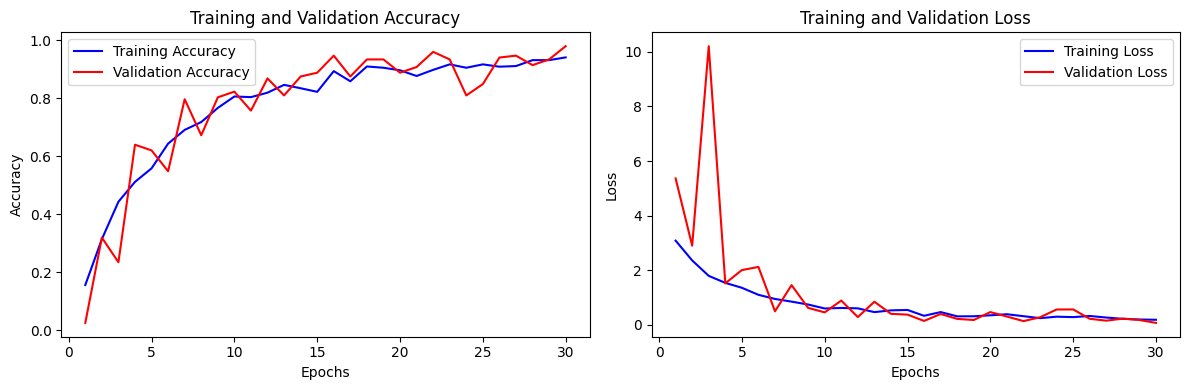

In [24]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/30
172/172 [==============================] - 98s 166ms/step - loss: 2.7907 - accuracy: 0.2442 - val_loss: 4.0750 - val_accuracy: 0.2549
Epoch 2/30
172/172 [==============================] - 26s 152ms/step - loss: 1.8252 - accuracy: 0.4825 - val_loss: 2.5941 - val_accuracy: 0.4118
Epoch 3/30
172/172 [==============================] - 23s 135ms/step - loss: 1.3960 - accuracy: 0.5707 - val_loss: 1.7714 - val_accuracy: 0.6144
Epoch 4/30
172/172 [==============================] - 23s 136ms/step - loss: 1.1965 - accuracy: 0.6283 - val_loss: 1.1372 - val_accuracy: 0.6928
Epoch 5/30
172/172 [==============================] - 22s 129ms/step - loss: 1.0286 - accuracy: 0.6917 - val_loss: 0.7644 - val_accuracy: 0.7712
Epoch 6/30
172/172 [==============================] - 23s 136ms/step - loss: 0.8966 - accuracy: 0.7208 - val_loss: 0.5245 - val_accuracy: 0.8301
Epoch 7/30
172/172 [==============================] - 23s 133ms/s

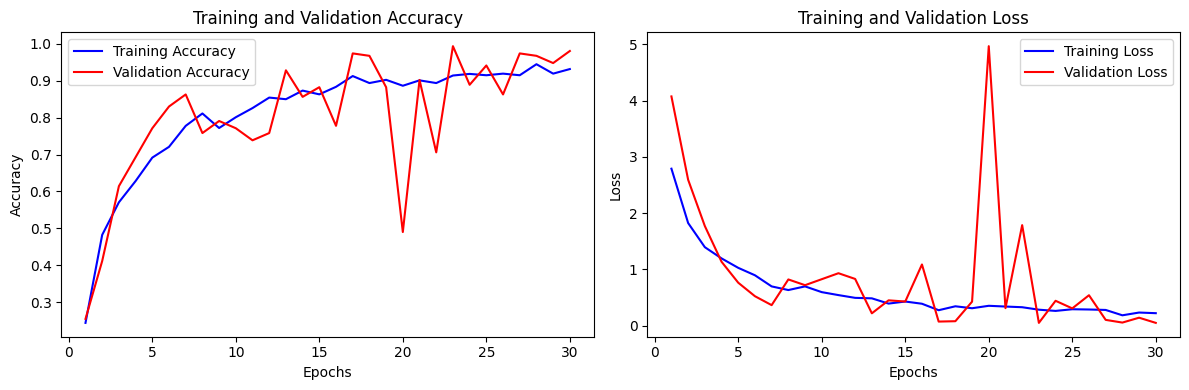

In [12]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    model = models.Sequential()

    # Layer 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())

    # Layer 2
    model.add(layers.Conv2D(256, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())

    # Layer 3
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # Layer 4
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())

    # Layer 5
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(layers.BatchNormalization())

    # Flatten
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1000, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 19
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/19
172/172 [==============================] - 8s 25ms/step - loss: 3.3893 - accuracy: 0.2704 - val_loss: 12.7006 - val_accuracy: 0.1503
Epoch 2/19
172/172 [==============================] - 4s 22ms/step - loss: 1.9865 - accuracy: 0.4665 - val_loss: 4.5358 - val_accuracy: 0.2484
Epoch 3/19
172/172 [==============================] - 4s 21ms/step - loss: 1.5513 - accuracy: 0.5736 - val_loss: 2.1606 - val_accuracy: 0.4771
Epoch 4/19
172/172 [==============================] - 4s 21ms/step - loss: 1.4022 - accuracy: 0.5933 - val_loss: 2.6266 - val_accuracy: 0.5556
Epoch 5/19
172/172 [==============================] - 4s 22ms/step - loss: 1.2902 - accuracy: 0.6531 - val_loss: 1.1685 - val_accuracy: 0.6928
Epoch 6/19
172/172 [==============================] - 4s 24ms/step - loss: 1.1550 - accuracy: 0.6749 - val_loss: 0.7700 - val_accuracy: 0.7386
Epoch 7/19
172/172 [==============================] - 3s 20ms/step - loss: 1.1474 - accuracy: 0.6975 - val_loss: 0.8220 - val_accuracy: 0.758

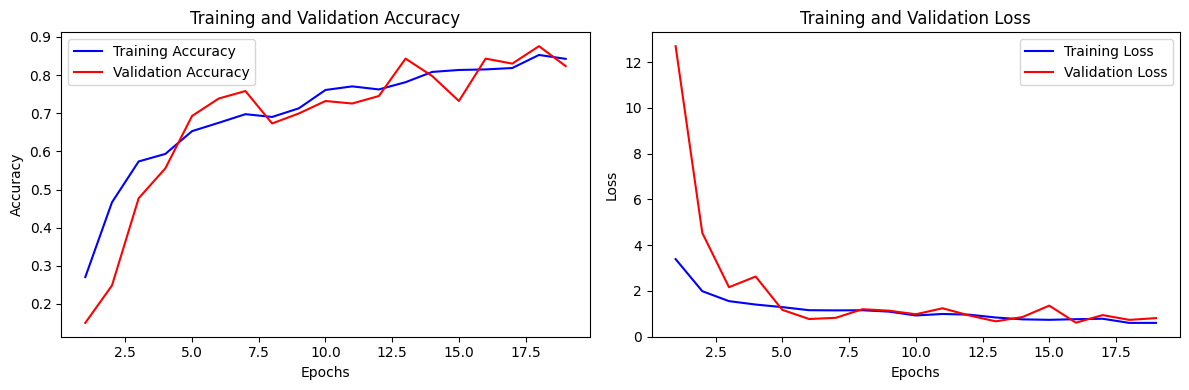

In [15]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/30
172/172 [==============================] - 53s 154ms/step - loss: 2.6646 - accuracy: 0.2711 - val_loss: 52.7476 - val_accuracy: 0.1176
Epoch 2/30
172/172 [==============================] - 24s 141ms/step - loss: 1.7072 - accuracy: 0.5007 - val_loss: 2.3518 - val_accuracy: 0.6144
Epoch 3/30
172/172 [==============================] - 23s 135ms/step - loss: 1.2222 - accuracy: 0.6290 - val_loss: 1.6431 - val_accuracy: 0.6078
Epoch 4/30
172/172 [==============================] - 24s 137ms/step - loss: 0.8076 - accuracy: 0.7609 - val_loss: 2.9618 - val_accuracy: 0.4444
Epoch 5/30
172/172 [==============================] - 23s 136ms/step - loss: 0.7771 - accuracy: 0.7762 - val_loss: 0.2450 - val_accuracy: 0.9216
Epoch 6/30
172/172 [==============================] - 24s 137ms/step - loss: 0.4958 - accuracy: 0.8484 - val_loss: 1.1397 - val_accuracy: 0.8039
Epoch 7/30
172/172 [==============================] - 23s 135ms/

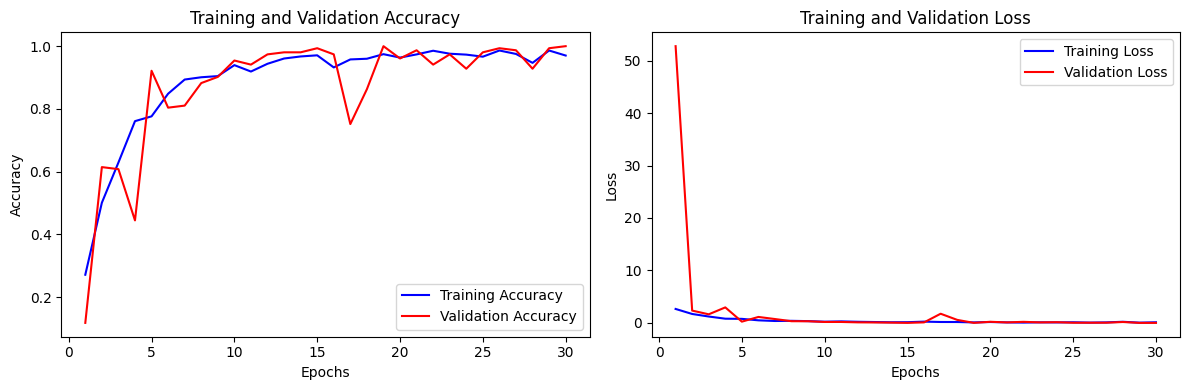

In [14]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/30
172/172 [==============================] - 58s 100ms/step - loss: 1.4195 - accuracy: 0.6254 - val_loss: 0.4573 - val_accuracy: 0.9085
Epoch 2/30
172/172 [==============================] - 15s 86ms/step - loss: 0.5513 - accuracy: 0.8426 - val_loss: 0.1547 - val_accuracy: 0.9542
Epoch 3/30
172/172 [==============================] - 15s 89ms/step - loss: 0.3255 - accuracy: 0.9045 - val_loss: 0.3646 - val_accuracy: 0.9020
Epoch 4/30
172/172 [==============================] - 15s 85ms/step - loss: 0.2667 - accuracy: 0.9271 - val_loss: 0.0193 - val_accuracy: 0.9935
Epoch 5/30
172/172 [==============================] - 15s 87ms/step - loss: 0.3220 - accuracy: 0.9206 - val_loss: 4.3536 - val_accuracy: 0.4706
Epoch 6/30
172/172 [==============================] - 15s 87ms/step - loss: 0.2285 - accuracy: 0.9286 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 7/30
172/172 [==============================] - 15s 85ms/step - 

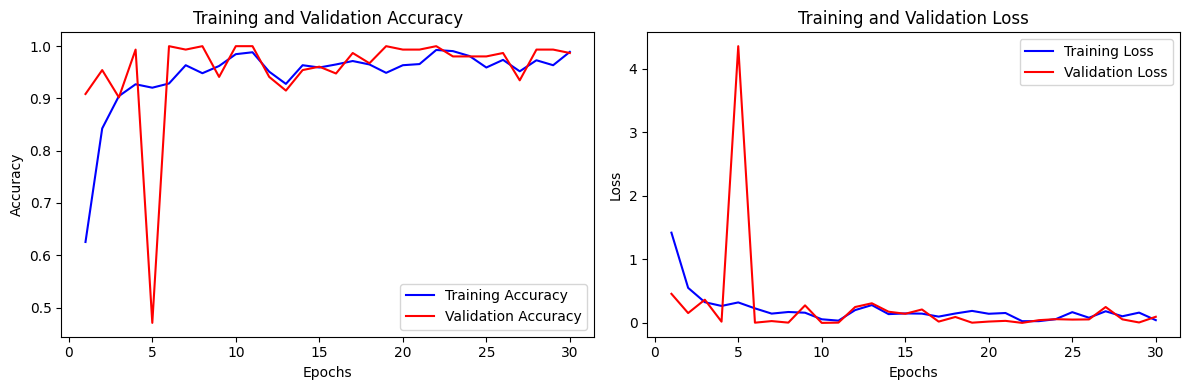

In [16]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.NASNetMobile(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 12
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/12
172/172 [==============================] - 169s 191ms/step - loss: 2.0495 - accuracy: 0.4614 - val_loss: 77.2281 - val_accuracy: 0.0261
Epoch 2/12
172/172 [==============================] - 29s 167ms/step - loss: 1.1434 - accuracy: 0.6888 - val_loss: 1163.6454 - val_accuracy: 0.0327
Epoch 3/12
172/172 [==============================] - 29s 169ms/step - loss: 0.7020 - accuracy: 0.8061 - val_loss: 123.0199 - val_accuracy: 0.0523
Epoch 4/12
172/172 [==============================] - 29s 166ms/step - loss: 0.6456 - accuracy: 0.8345 - val_loss: 80.5077 - val_accuracy: 0.0000e+00
Epoch 5/12
172/172 [==============================] - 28s 165ms/step - loss: 0.5182 - accuracy: 0.8520 - val_loss: 520.5500 - val_accuracy: 0.0458
Epoch 6/12
172/172 [==============================] - 29s 171ms/step - loss: 0.3331 - accuracy: 0.9111 - val_loss: 57.3633 - val_accuracy: 0.1307
Epoch 7/12
172/172 [==============================] - 29s 166ms/step - loss: 0.3176 - accuracy: 0.9096 - val_loss: 

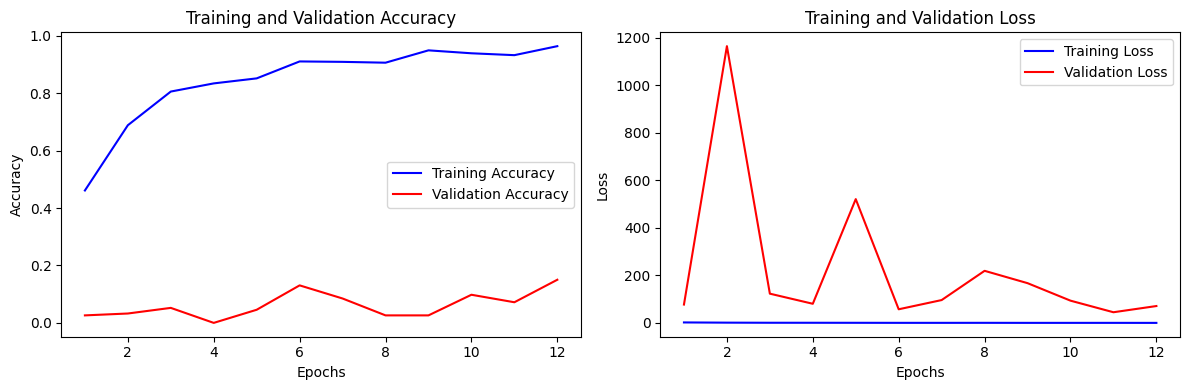

In [14]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.MobileNet(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 10
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/10
172/172 [==============================] - 21s 39ms/step - loss: 1.8911 - accuracy: 0.5080 - val_loss: 3.2305 - val_accuracy: 0.2941
Epoch 2/10
172/172 [==============================] - 6s 38ms/step - loss: 0.9958 - accuracy: 0.7077 - val_loss: 0.9978 - val_accuracy: 0.6797
Epoch 3/10
172/172 [==============================] - 6s 36ms/step - loss: 0.6394 - accuracy: 0.8178 - val_loss: 0.2294 - val_accuracy: 0.9150
Epoch 4/10
172/172 [==============================] - 6s 36ms/step - loss: 0.5587 - accuracy: 0.8404 - val_loss: 0.5337 - val_accuracy: 0.8039
Epoch 5/10
172/172 [==============================] - 6s 37ms/step - loss: 0.4469 - accuracy: 0.8841 - val_loss: 0.2134 - val_accuracy: 0.9346
Epoch 6/10
172/172 [==============================] - 6s 35ms/step - loss: 0.2963 - accuracy: 0.9118 - val_loss: 0.0875 - val_accuracy: 0.9673
Epoch 7/10
172/172 [==============================] - 7s 38ms/step - loss: 0.3575 - accuracy: 0.9009 - val_loss: 0.0833 - val_accuracy: 0.980

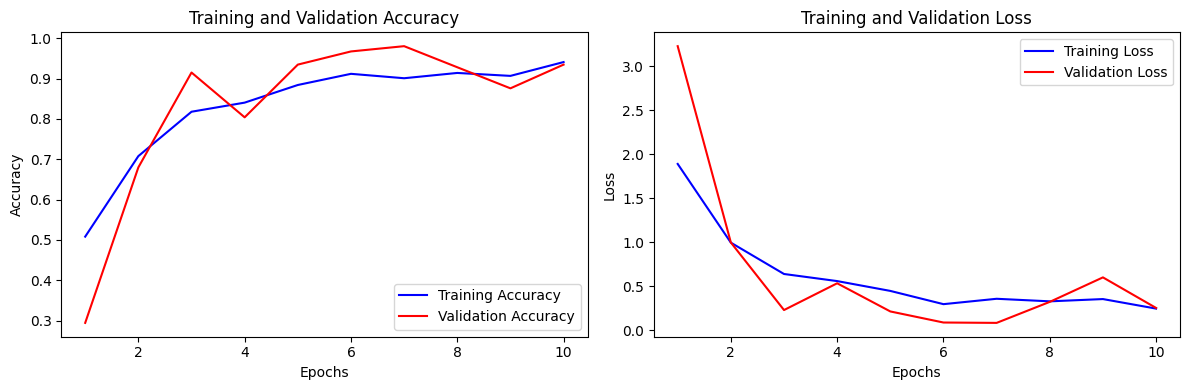

In [12]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

with strategy.scope():
    base_model = tf.keras.applications.ResNet101(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )

    # Add a GlobalAveragePooling2D layer to replace the Flatten layer
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 30
    batch_size = 8

    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

171446536/171446536 [==============================] - 1s 0us/step
Epoch 1/30
172/172 [==============================] - 120s 215ms/step - loss: 3.0702 - accuracy: 0.1749 - val_loss: 74.5161 - val_accuracy: 0.0261
Epoch 2/30
172/172 [==============================] - 31s 180ms/step - loss: 2.4460 - accuracy: 0.2471 - val_loss: 3.1621 - val_accuracy: 0.2614
Epoch 3/30
172/172 [==============================] - 31s 182ms/step - loss: 1.9696 - accuracy: 0.3878 - val_loss: 11.9477 - val_accuracy: 0.0327
Epoch 4/30
172/172 [==============================] - 32s 183ms/step - loss: 1.6782 - accuracy: 0.4803 - val_loss: 1.3351 - val_accuracy: 0.5752
Epoch 5/30
172/172 [==============================] - 32s 184ms/step - loss: 1.3504 - accuracy: 0.5554 - val_loss: 3.9594 - val_accuracy: 0.3203
Epoch 6/30
172/172 [==============================] - 32s 184ms/step - loss: 1.1884 - accuracy: 0.6093 - val_loss: 0.7472 - val_accuracy: 0.7582
Epoch 7/30
172/172 [==============================] - 32s 18

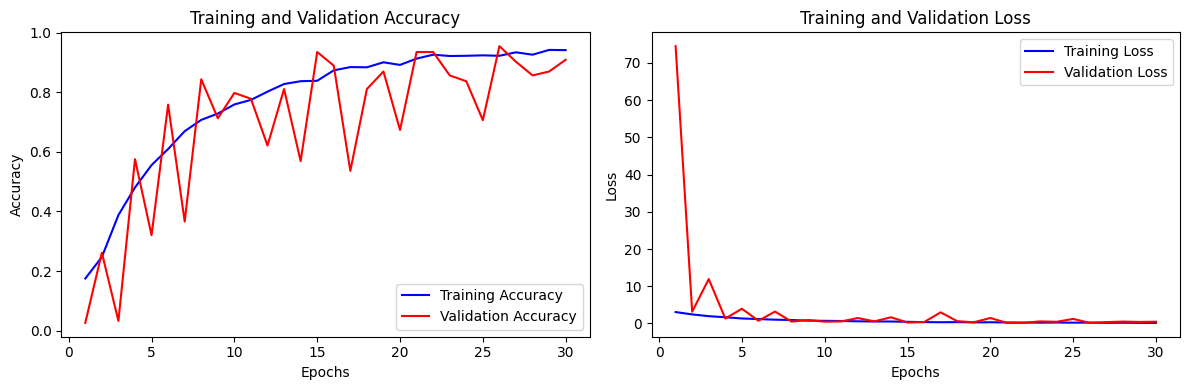

In [9]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history)

In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


with strategy.scope():
  X_train_flattened = X_train.reshape((X_train.shape[0], -1))
  X_test_flattened = X_test.reshape((X_test.shape[0], -1))

  svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))

  svm_model.fit(X_train_flattened, y_train)

  svm_predictions = svm_model.predict(X_test_flattened)

  svm_accuracy = accuracy_score(y_test, svm_predictions)
  print(f'SVM Accuracy: {svm_accuracy:.4f}')

SVM Accuracy: 0.8482


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


with strategy.scope():
  X_train = X_train.reshape((X_train.shape[0], -1))
  X_test = X_test.reshape((X_test.shape[0], -1))
  rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

  rf_model.fit(X_train, y_train)

  rf_predictions = rf_model.predict(X_test)

  rf_accuracy = accuracy_score(y_test, rf_predictions)
  print(f'Random Forest Accuracy: {rf_accuracy:.4f}')

Random Forest Accuracy: 0.8534


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


with strategy.scope():
  X_train = X_train.reshape((X_train.shape[0], -1))
  X_test = X_test.reshape((X_test.shape[0], -1))
  dt_model = DecisionTreeClassifier(random_state=42)

  dt_model.fit(X_train, y_train)

  dt_predictions = dt_model.predict(X_test)

  dt_accuracy = accuracy_score(y_test, dt_predictions)
  print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.5995
